In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
import xarray as xr
import cmocean as cm
import marineHeatWaves as mhw
from datetime import date

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data

In [3]:
file_name = "data/rteb1_after_filter_1D.nc"
ds_eb = xr.open_dataset(file_name)

In [4]:
file_name = "data/rtwb_after_filter_1D.nc"
ds_wb = xr.open_dataset(file_name)

In [5]:
file_name = "data/ORAS5.nc"
oras5 = xr.open_dataset(file_name)

In [6]:
oras5_EB= oras5.sel(latitude = 57.1, longitude = -9.6 -1, method = 'nearest')
oras5_WB = oras5.sel(latitude = 57.5, longitude = -12.5, method = 'nearest')

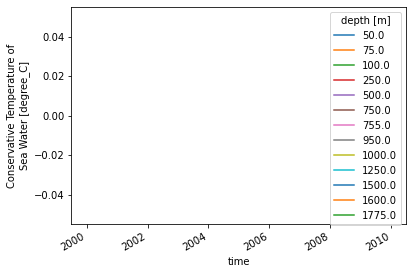

In [29]:
ds_eb.temp.plot.line(x='time');

## Functions

In [7]:
def MHW_func (data, depth, climP=[2014.0,2020.0], altClim=False):
    yy_start = int(data.time[0].dt.year)
    yy_end = int(data.time[-1].dt.year)
    mm_start = int(data.time[0].dt.month)
    mm_end = int(data.time[-1].dt.month)
    dd_start = int(data.time[0].dt.day)
    dd_end = int(data.time[-1].dt.day)
    
    t = np.arange(
        date(yy_start, mm_start, dd_start).toordinal(),                 # .toordinal turns the date into a number that the algorithm can process
        date(yy_end, mm_end, dd_end).toordinal()+1,1) 
    
    temp = data.sel(depth=depth, method = 'nearest').squeeze().values   # by using .squeeze().values we are first removing any other depth and then turning the data into a 1d numpy array 
                                                                        # without doing this the data will still be in an array and the algorithm can't handle it
    
    mhws, clim = mhw.detect(t, temp, climatologyPeriod=climP, alternateClimatology=altClim)                                    # using the algorithm
    mcss, clim_cold = mhw.detect(t, temp, coldSpells = True, climatologyPeriod=climP, alternateClimatology=altClim)            # cold spells 
    return mhws, mcss, clim, clim_cold, t, temp  

In [8]:
def DICT_func(data, depth, climP=[2014,2020], altClim= False, altT=False, altData=False):  
    # define 6 empty dictionaries
    mhws_,mcss_,clim_,clim_cold_,t_,temp_ = {},{},{},{},{},{}

    # Iterating through all instrument depths       
    for n in depth:
        
        if altClim:
            temp_oras = np.array(altData.sel(depth=n, method= 'nearest'))
            altClim=[altT,temp_oras]

        mhws, mcss, clim, clim_cold, t, temp = MHW_func(data, n, climP=climP, altClim=altClim)
        mhws_.update({str(n):mhws})
        mcss_.update({str(n):mcss})
        clim_.update({str(n):clim})
        clim_cold_.update({str(n):clim_cold})
        t_.update({str(n):t})
        temp_.update({str(n):temp})
    
    dictionary = {'mhws':mhws_,'mcss':mcss_,'clim':clim_,'clim_cold':clim_cold_,'t':t_,'temp':temp_}
    return dictionary

In [9]:
#fig, ax = plt.subplots(3,1, figsize= (15,5))
def MHW_plot(t,temp,clim,ax):

    
    ax.plot(t,temp,label='temp', color='grey', linewidth='.75')
    ax.plot(t,clim['seas'],label='clim', color='b')
    ax.plot(t,clim['thresh'], label='thresh', color='r')
    #plt.plot(ds1D.TIME,clim_cold['thresh'], label='thresh')
    ax.legend()

    yloc = YearLocator()
    mloc = MonthLocator()
    ax.xaxis.set_major_locator(yloc)
    ax.xaxis.set_minor_locator(mloc)

    ax.grid()

In [10]:
def ALL_events(dict, n):
    
    #defining my variables
    mhws = dict['mhws'][str(n)]
    mcss = dict['mcss'][str(n)]
    t = dict['t'][str(n)]
    temp = dict['temp'][str(n)]
    clim = dict['clim'][str(n)]
    clim_cold = dict['clim_cold'][str(n)]
    
    dates = [date.fromordinal(tt.astype(int)) for tt in t]

    ev = (mhws['n_events'])
    ec = (mcss['n_events'])


    plt.figure(figsize=(30,15))
    plt.subplot(2,1,1)

    # Plot t, seasonal cycle, and threshold
    plt.plot(dates, clim['thresh'], ':r', label = 'Threshold warm')
    plt.plot(dates, clim_cold['thresh'], ':g', label = 'Threshold cold')
    plt.plot(dates, temp, 'k', label = 'Temperature', linewidth = .75)
    plt.plot(dates, clim['seas'], 'b', label = 'Climatology')
    plt.legend()
    plt.title('Data Overview')
    plt.xlim(dates[0], dates[-1])
    #plt.xlim(date(2016,1,1), date(2017,5,1))
    plt.ylim(temp.min()-0.1, temp.max()+0.1)
    plt.ylabel(r't $^\circ$C')
    plt.grid()

    # plt the heatwaves
    plt.subplot(2,1,2)

    # Find all MHWs and shade
    for ev0 in np.arange (ev):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]
        plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], \
                         color='pink')

    # Find MHW of interest and shade accordingly
    ev_i = np.argmax(mhws['intensity_max'])
    t1 = np.where(t==mhws['time_start'][ev_i])[0][0]
    t2 = np.where(t==mhws['time_end'][ev_i])[0][0]
    plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color='deeppink', label = 'MHW event with max intensity')


    # same for cold spells
    for ec0 in np.arange(ec):
        tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
        tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
        plt.fill_between(dates[tc1:tc2+1], temp[tc1:tc2+1], clim_cold['thresh'][tc1:tc2+1], \
                         color='cyan')

    # Find MCSS of interest and shade accordingly
    ec_i = np.argmin(mcss['intensity_max'])
    tc1 = np.where(t==mcss['time_start'][ec_i])[0][0]
    tc2 = np.where(t==mcss['time_end'][ec_i])[0][0]
    plt.fill_between(dates[tc1:tc2+1], temp[tc1:tc2+1], clim_cold['thresh'][tc1:tc2+1], \
                     color='darkcyan', label = 'MCSS event with max intensity')    

    # Plot t, seasonal cycle, threshold, shade MHWs with main event in red
    plt.plot(dates, clim['thresh'], ':r', linewidth=2, label = 'Threshold warm')
    plt.plot(dates, clim_cold['thresh'], ':g', linewidth=2, label = 'Threshold cold')
    plt.plot(dates, temp, 'k', linewidth=.75, label = 'Temperature')
    plt.plot(dates, clim['seas'], 'b', linewidth=2, label = 'Climatology')
    plt.legend()
    plt.title('Marine Heatwaves and Cold Spells')
    #plt.xlim(date(2016,1,1), date(2016,12,31))
    plt.xlim(dates[0], dates[-1])
    #plt.xlim(mhws['date_start'][ev-12], mhws['date_end'][ev+4])
    plt.ylim(temp.min()-0.1, temp.max()+0.1)
    plt.grid()
    plt.ylabel(r't $^\circ$C');
    
    #print some intersting stats
    print('Overview:')
    print('Number of MHWs: ', ev)
    print('Number of MCSs: ', ec)
    print('The MHWs of max intensity lastet from the', mhws['date_start'][ev_i], 'to the', mhws['date_end'][ev_i])
    print('The MCSs of max intensity lastet from the', mcss['date_start'][ec_i], 'to the', mcss['date_end'][ec_i])
    print(' ')

#plt.savefig('100m_EAST_zoom_2016-2017', dpi = 300)

In [11]:
def OV_events(dict, n):
    
    #defining my variables
    mhws = dict['mhws'][str(n)]
    mcss = dict['mcss'][str(n)]
    t = dict['t'][str(n)]
    temp = dict['temp'][str(n)]
    clim = dict['clim'][str(n)]
    clim_cold = dict['clim_cold'][str(n)]
    
    dates = [date.fromordinal(tt.astype(int)) for tt in t]

    ev = (mhws['n_events'])
    ec = (mcss['n_events'])


    #plt.figure(figsize=(30,1),frameon=False)
    #plt.subplot(1,1,1)


    # Find all MHWs and shade
    for ev0 in np.arange (ev):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]
        plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], \
                         color='deeppink')

    # same for cold spells
    for ec0 in np.arange(ec):
        tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
        tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
        plt.fill_between(dates[tc1:tc2+1], temp[tc1:tc2+1], clim_cold['thresh'][tc1:tc2+1], \
                         color='darkcyan')

    # Plot t, seasonal cycle, threshold, shade MHWs with main event in red
    plt.plot(dates, clim['thresh'], ':r', linewidth=0.1, label = 'Threshold warm')
    plt.plot(dates, clim_cold['thresh'], ':g', linewidth=0.1, label = 'Threshold cold')
    plt.plot(dates, temp, 'k', linewidth=.1, label = 'Temperature')
    plt.plot(dates, clim['seas'], 'b', linewidth=.1, label = 'Climatology')
    #plt.legend()
    plt.title('Marine Heatwaves and Cold Spells')
    #plt.xlim(date(2016,1,1), date(2016,12,31))
    plt.xlim(dates[0], dates[-1])
    #plt.xlim(mhws['date_start'][ev-12], mhws['date_end'][ev+4])
    #plt.ylim(temp.min()-0.1, temp.max()+0.1)
    plt.grid()
    plt.ylabel(r't $^\circ$C')
    
    fig.tight_layout()
    
    ;


In [12]:
def OV_stacked_events(dict, n):
    
    #defining my variables
    mhws = dict['mhws'][str(n)]
    mcss = dict['mcss'][str(n)]
    t = dict['t'][str(n)]
    temp = dict['temp'][str(n)]
    clim = dict['clim'][str(n)]
    clim_cold = dict['clim_cold'][str(n)]
    
    dates = [date.fromordinal(tt.astype(int)) for tt in t]
    
    
    ev = (mhws['n_events'])
    ec = (mcss['n_events'])

    fig, ax = plt.subplots(figsize=(30,1),frameon=False)
    plt.subplot(1,1,1)


    # Find all MHWs and shade
    for ev0 in np.arange (ev):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]
        
        plt.axvspan(xmin=dates[t1], xmax=dates[t2],color='deeppink')
        

    # same for cold spells
    for ec0 in np.arange(ec):
        tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
        tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
        
        plt.axvspan(xmin=dates[tc1], xmax=dates[tc2],color='darkcyan')
    
        
    # Plot t, seasonal cycle, threshold, shade MHWs with main event in red
    plt.plot(dates, clim['thresh'], ':r', linewidth=0.1, label = 'Threshold warm')
    plt.plot(dates, clim_cold['thresh'], ':g', linewidth=0.1, label = 'Threshold cold')
    plt.plot(dates, temp, 'k', linewidth=.1, label = 'Temperature')
    plt.plot(dates, clim['seas'], 'b', linewidth=.1, label = 'Climatology')
    
    if n == 50.0:
        plt.title('Marine Heatwaves and Cold Spells')
    #plt.legend()
    #plt.title('Marine Heatwaves and Cold Spells')
    plt.xlim(date(2014,7,15), date(2020,10,20))
    #plt.xlim(dates[0], dates[-1])
    #plt.xlim(mhws['date_start'][ev-12], mhws['date_end'][ev+4])
    #plt.ylim(temp.min()-0.1, temp.max()+0.1)
    plt.grid()
    #plt.ylabel(r't $^\circ$C')
    plt.ylabel(str(n))

    #plt.axis('off')

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    
    plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)
    
    if n == 1775.0:
        plt.tick_params(axis='x', which='both', bottom=True,
                top=False, labelbottom=True)

    if n == 1750.0:
        plt.tick_params(axis='x', which='both', bottom=True,
                top=False, labelbottom=True)
        
    plt.tick_params(axis='y', which='both', right=False,
                left=False, labelleft=False)

    
    ax = plt.gca()
    for spine in ['bottom']:
        ax.spines[spine].set_visible(False)
        
    if n == 1775.0:
        ax.spines['bottom'].set_visible(True)
    
    if n == 1750.0:
        ax.spines['bottom'].set_visible(True)
   
    #fig.suptitle('Marine Heatwaves and Cold Spells')
    ;
    

# Dictionary for EB and WB 'normal clim'

In [13]:
depth_EB = np.array(ds_eb.depth)
depth_WB = np.array(ds_wb.depth)

In [14]:
EB = DICT_func(ds_eb.temp, depth_EB)
WB = DICT_func(ds_wb.temp, depth_WB)

# Dictionary oras5_EB_10 and oras_WB_10 'alternative clim'

In [15]:
# alt clim from ORAS5 -› take only last 10 years of data
mhws_EB_10,mcss_EB_10,clim_EB_10,clim_cold_EB_10,t_EB_10,temp_EB_10 = {},{},{},{},{},{}

t_oras = np.arange(
        date(1993,1,1).toordinal(),
        date(2019,12,31).toordinal()+1,1)

# Iterating through all instrument depths
for n in depth_EB: 
    temp_oras = np.array(oras5_EB.thetao_oras.sel(depth=n, method= 'nearest'))
    
    mhws, mcss, clim, clim_cold, t, temp = MHW_func(ds_eb.temp, n, climP=[2010,2019], altClim=[t_oras,temp_oras])
    mhws_EB_10.update({str(n):mhws})
    mcss_EB_10.update({str(n):mcss})
    clim_EB_10.update({str(n):clim})
    clim_cold_EB_10.update({str(n):clim_cold})
    t_EB_10.update({str(n):t})
    temp_EB_10.update({str(n):temp})
    
oras5_EB_10 = {'mhws':mhws_EB_10,'mcss':mcss_EB_10,'clim':clim_EB_10,'clim_cold':clim_cold_EB_10,'t':t_EB_10,'temp':temp_EB_10}

In [16]:
# alt clim from ORAS5 -› take only last 10 years of data
mhws_WB_10,mcss_WB_10,clim_WB_10,clim_cold_WB_10,t_WB_10,temp_WB_10 = {},{},{},{},{},{}

t_oras = np.arange(
        date(1993,1,1).toordinal(),
        date(2019,12,31).toordinal()+1,1)

# Iterating through all instrument depths
for n in depth_WB: 
    temp_oras = np.array(oras5_WB.thetao_oras.sel(depth=n, method= 'nearest'))
    
    mhws, mcss, clim, clim_cold, t, temp = MHW_func(ds_wb.temp, n, climP=[2010,2019], altClim=[t_oras,temp_oras])
    mhws_WB_10.update({str(n):mhws})
    mcss_WB_10.update({str(n):mcss})
    clim_WB_10.update({str(n):clim})
    clim_cold_WB_10.update({str(n):clim_cold})
    t_WB_10.update({str(n):t})
    temp_WB_10.update({str(n):temp})
    
oras5_WB_10 = {'mhws':mhws_WB_10,'mcss':mcss_WB_10,'clim':clim_WB_10,'clim_cold':clim_cold_WB_10,'t':t_WB_10,'temp':temp_WB_10}

# Plotting the data

In [17]:
np.arange(len(depth_EB))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [18]:
np.arange(0,65,5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])

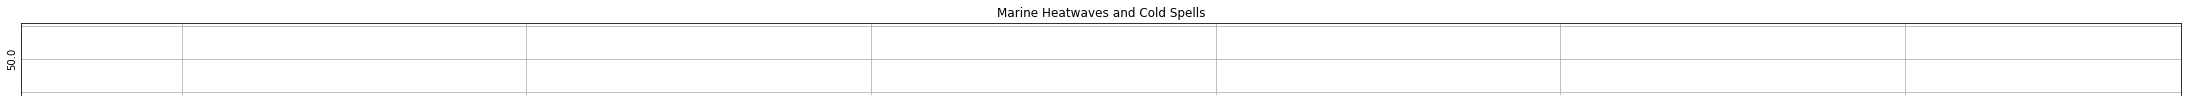

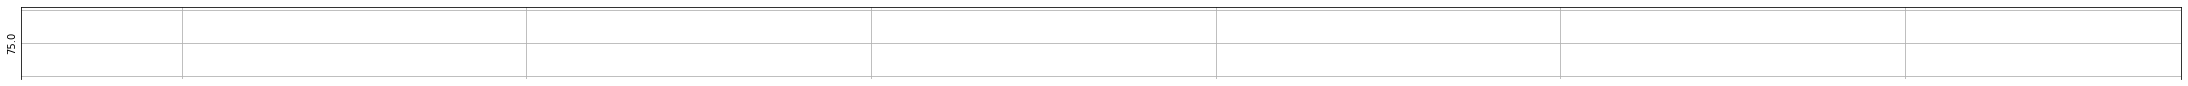

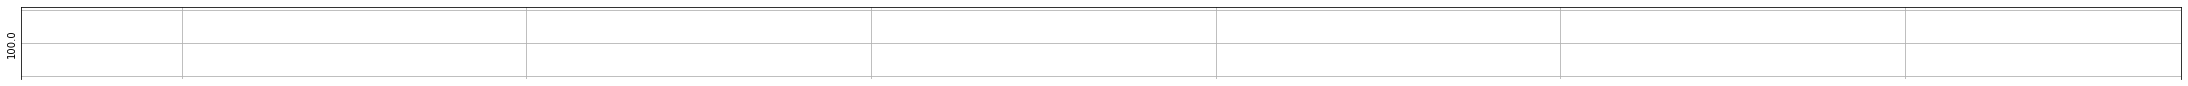

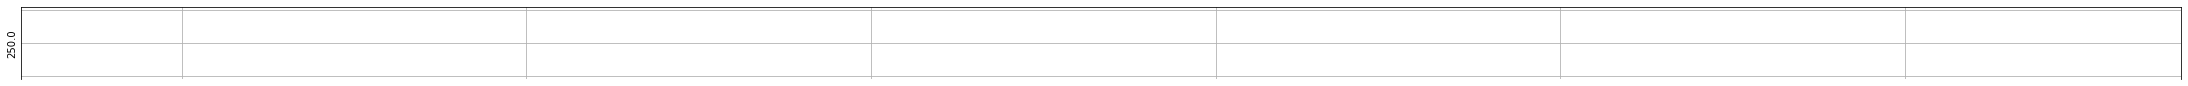

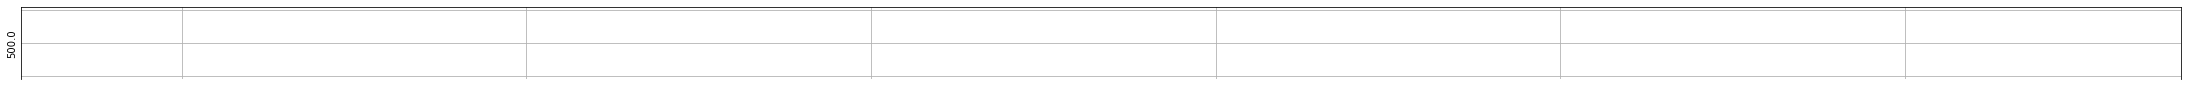

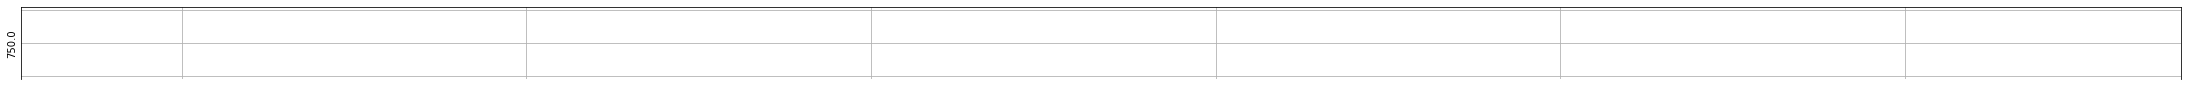

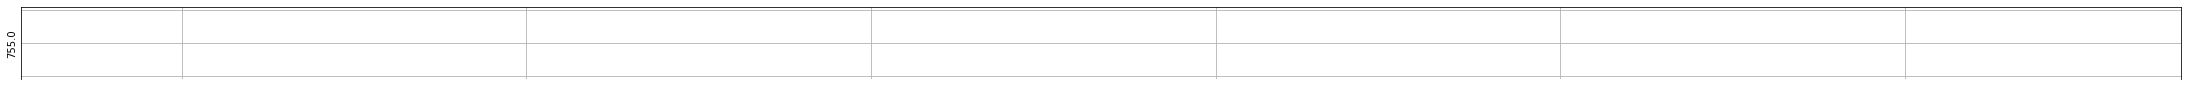

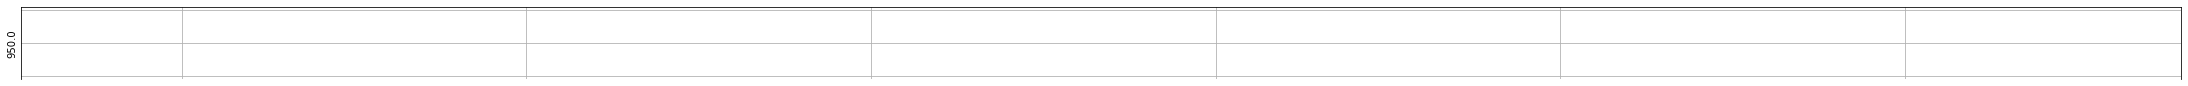

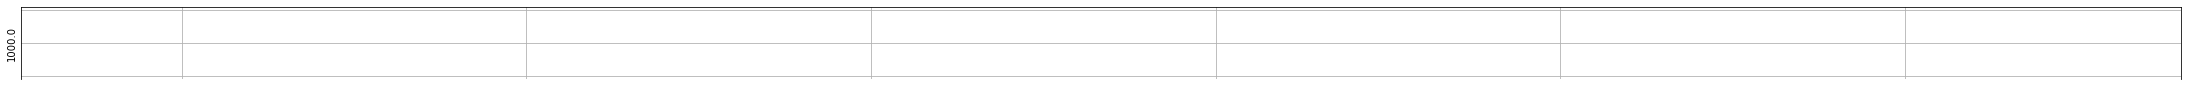

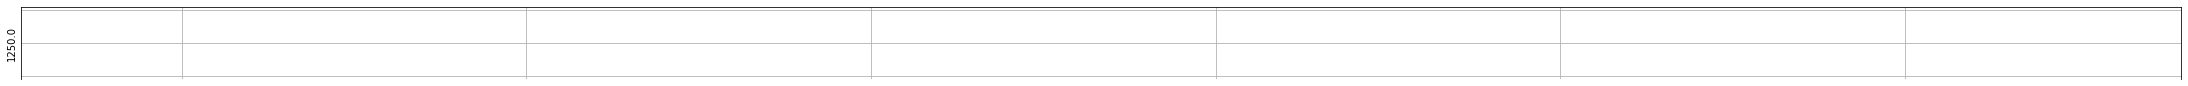

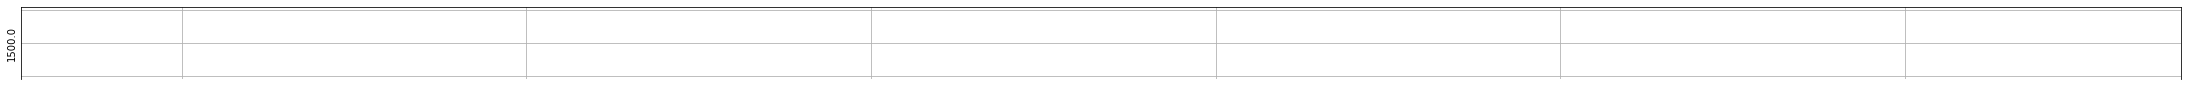

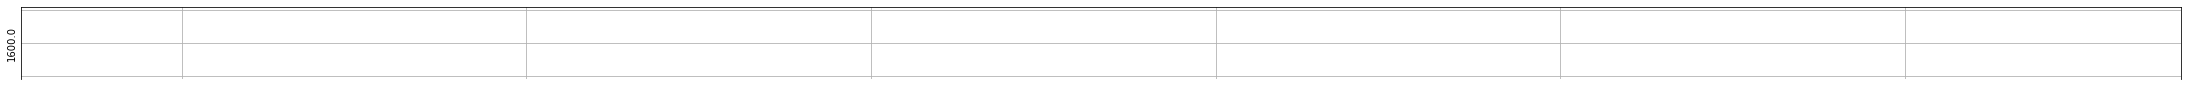

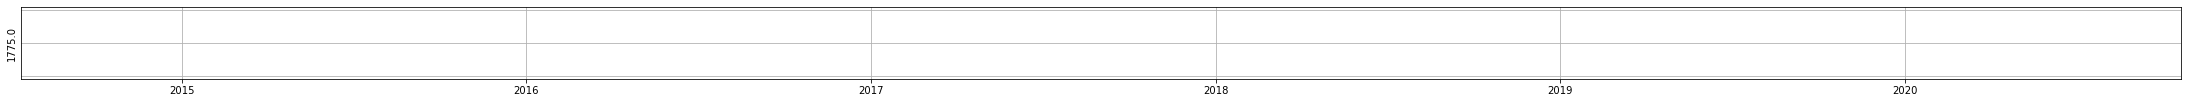

In [19]:
for n in depth_EB:
    OV_stacked_events(EB, n);

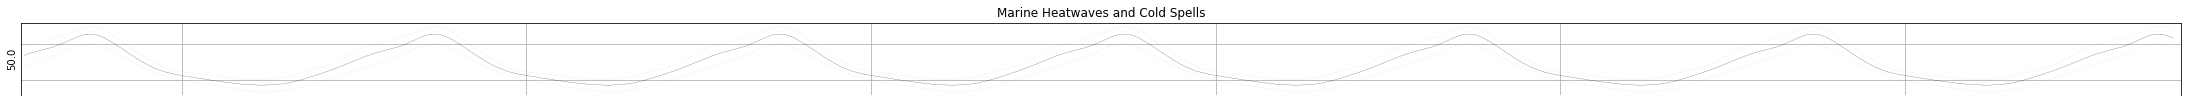

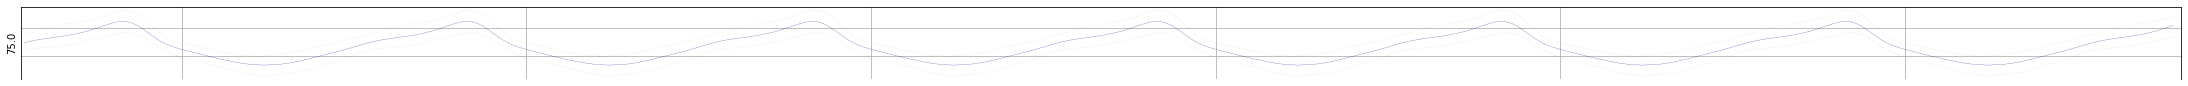

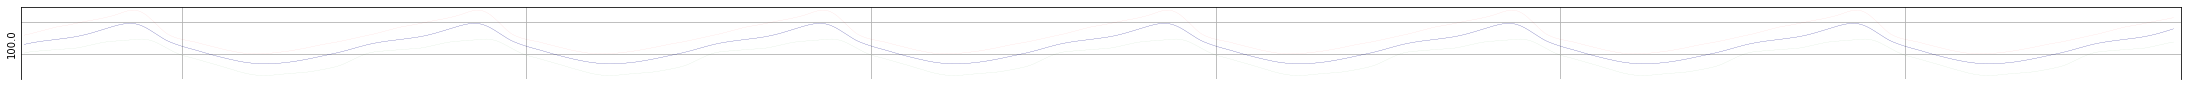

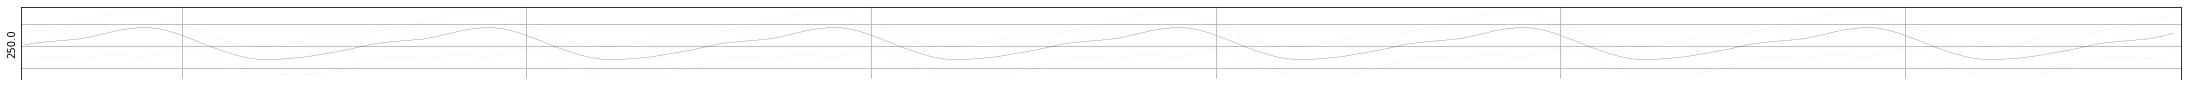

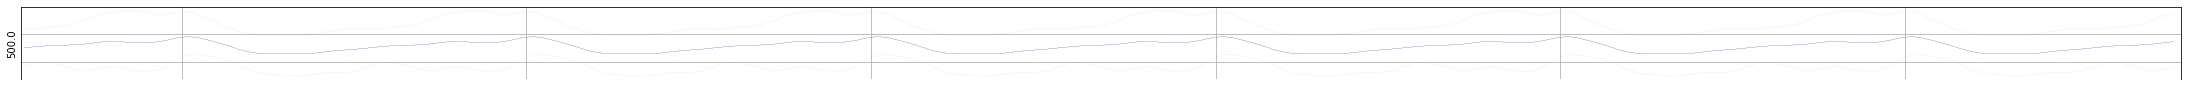

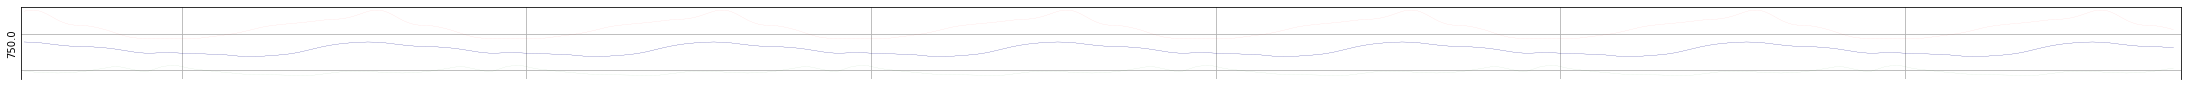

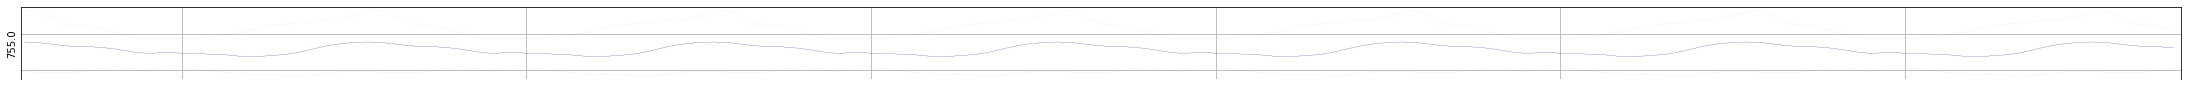

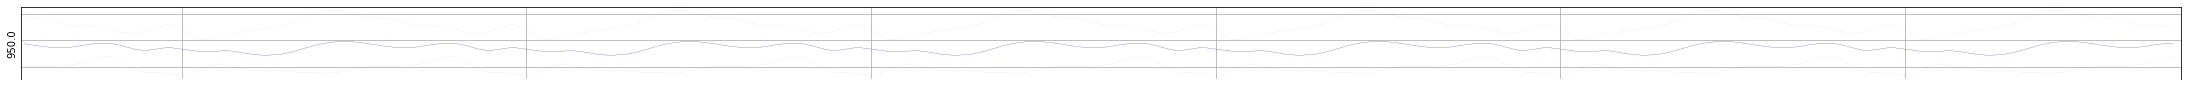

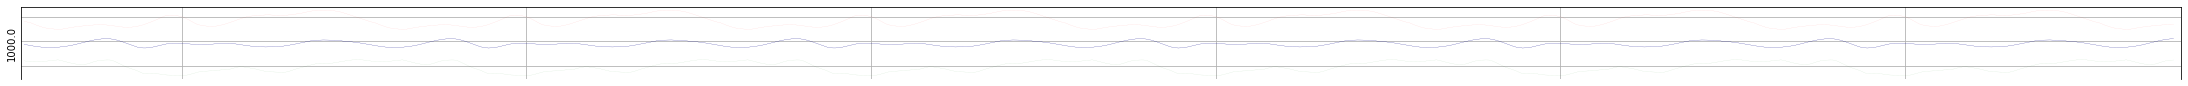

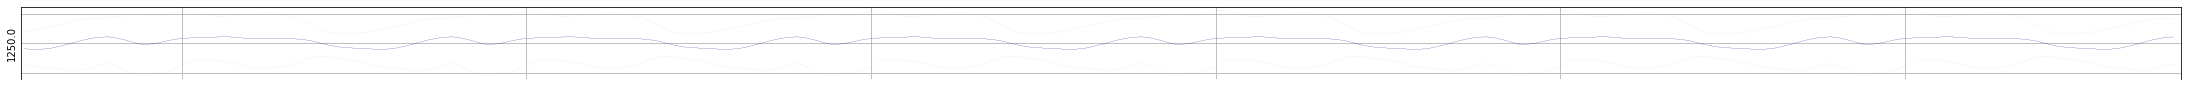

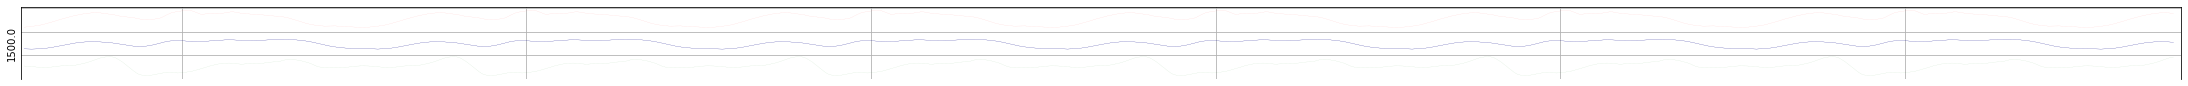

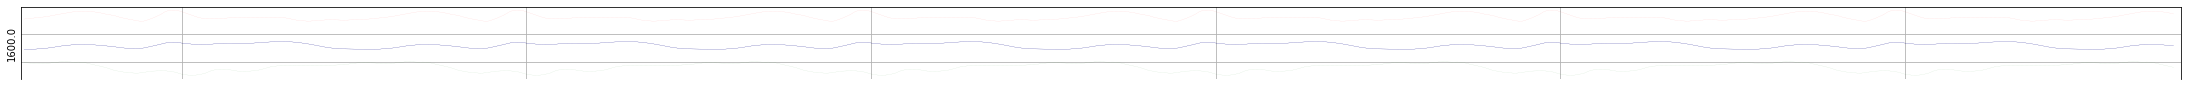

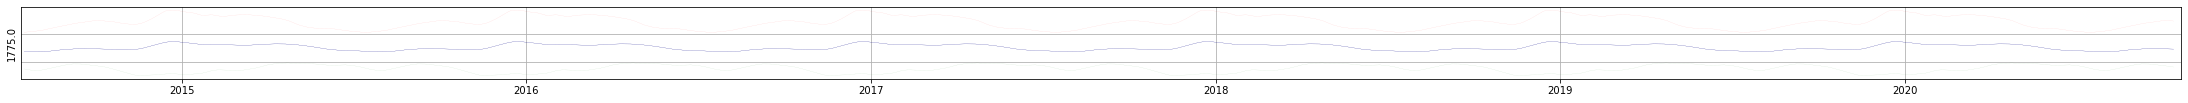

In [20]:
for n in depth_EB:
    OV_stacked_events(oras5_EB_10, n);

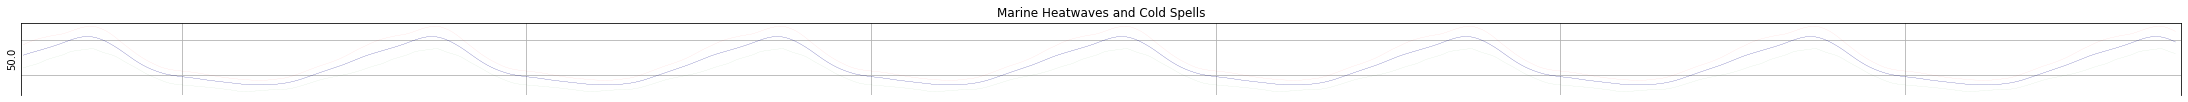

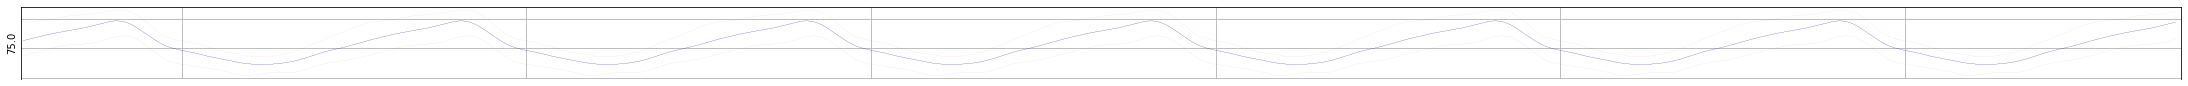

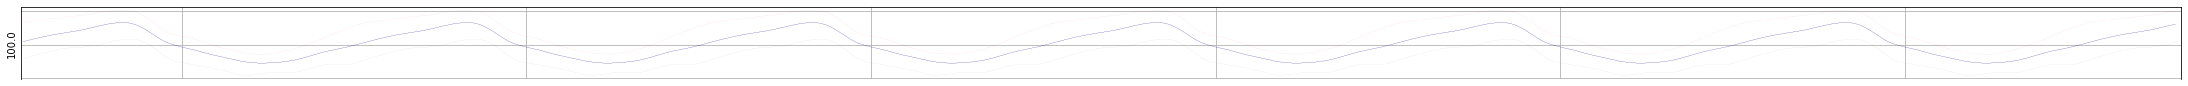

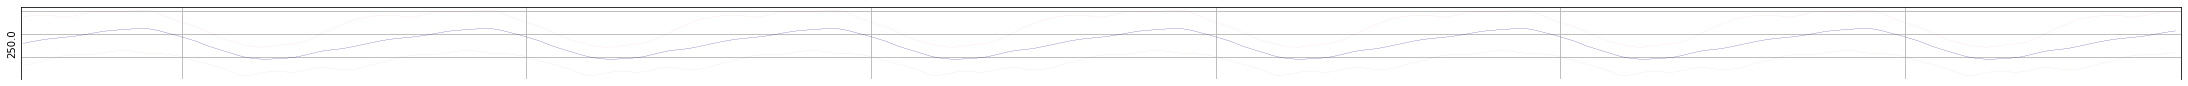

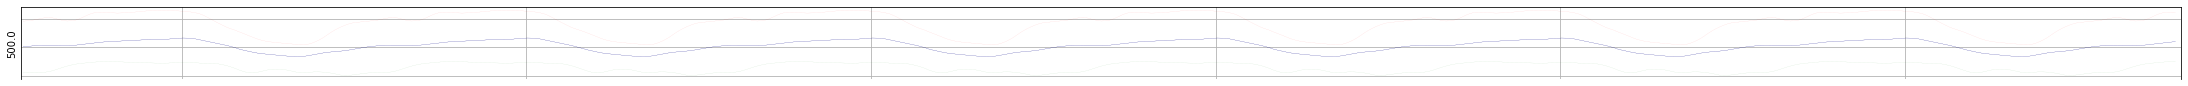

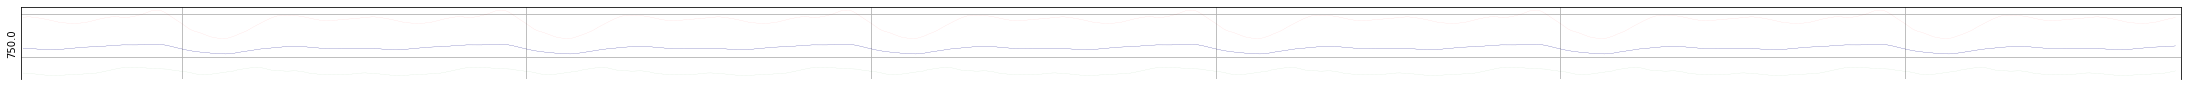

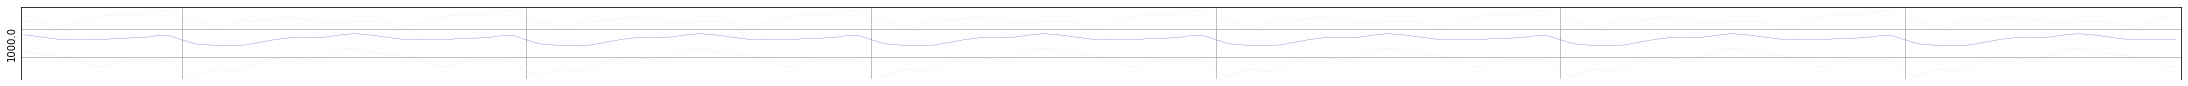

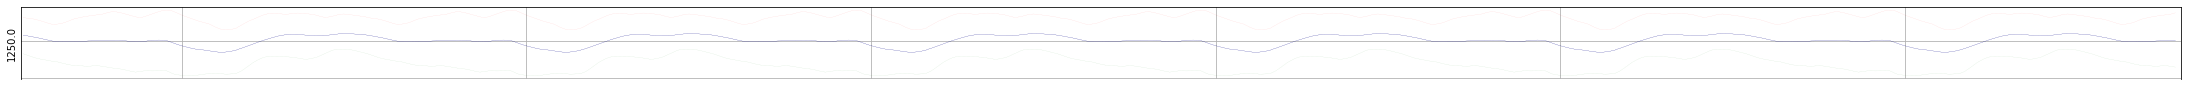

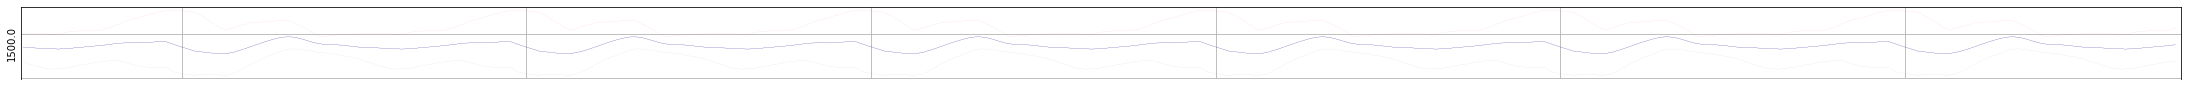

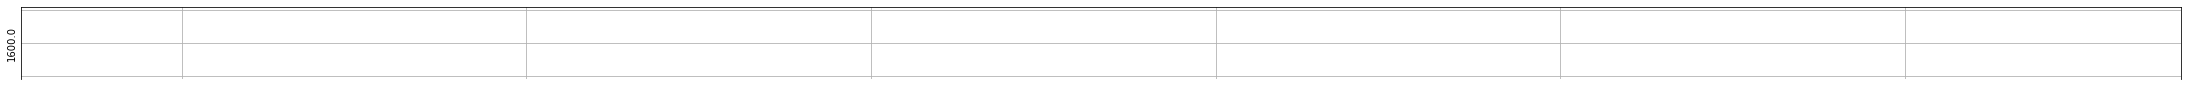

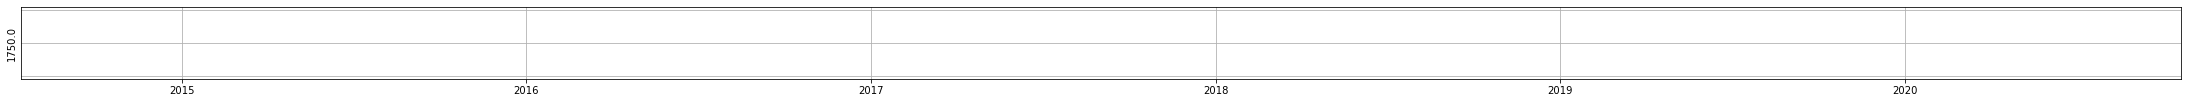

In [21]:
for n in depth_WB:
    OV_stacked_events(oras5_WB_10, n);

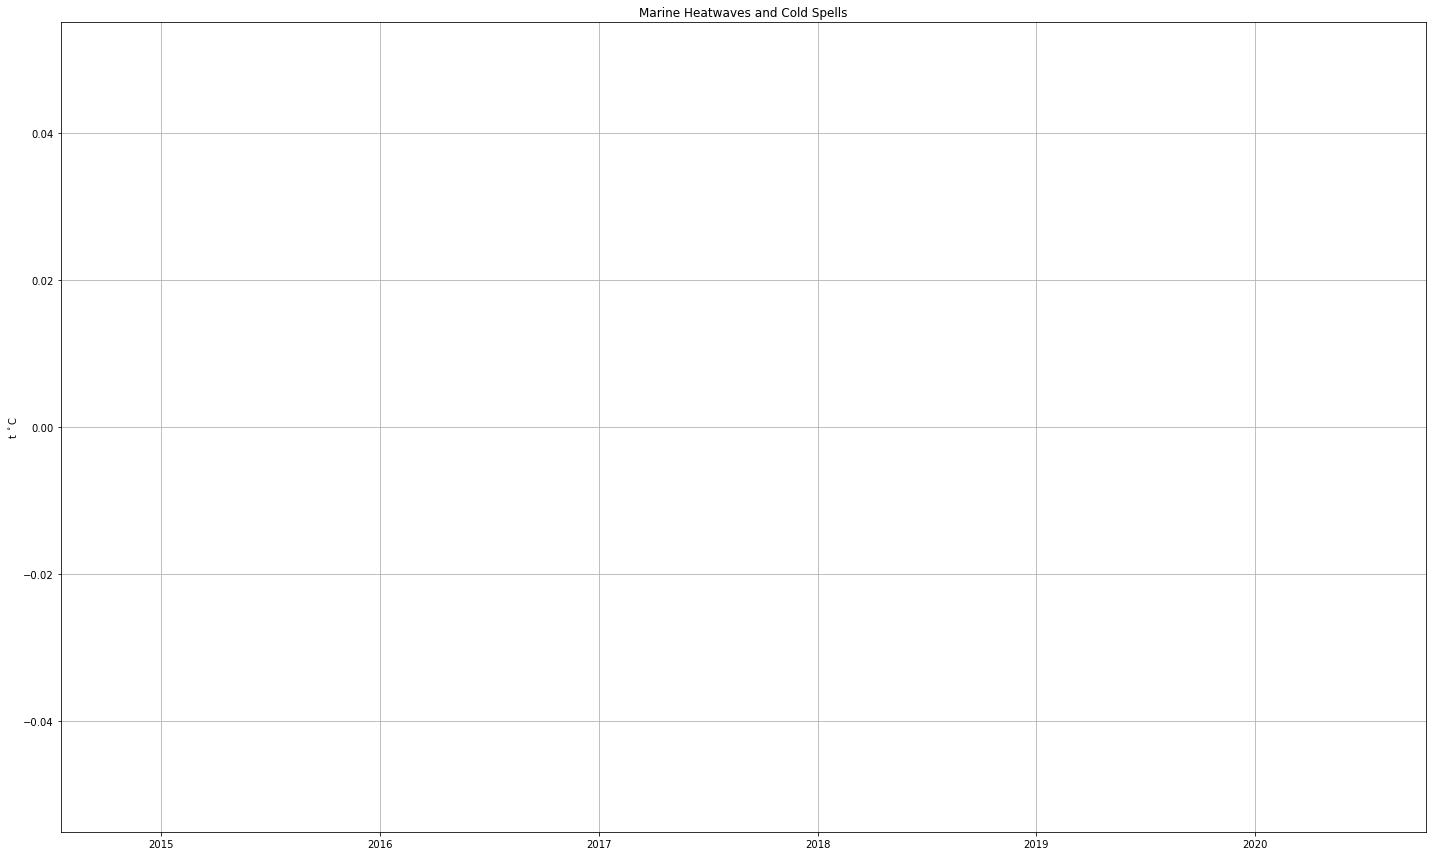

In [22]:
fig, ax=plt.subplots(figsize=(20,12))

for n in depth_EB:
    OV_events(EB, n)
    
#plt.savefig('figures/MHW and MCS in one figure', dpi =300)

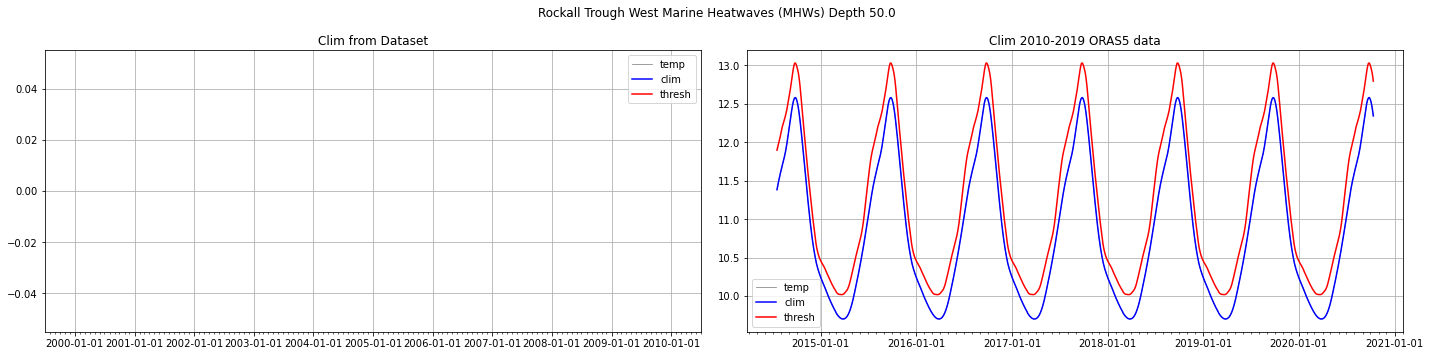

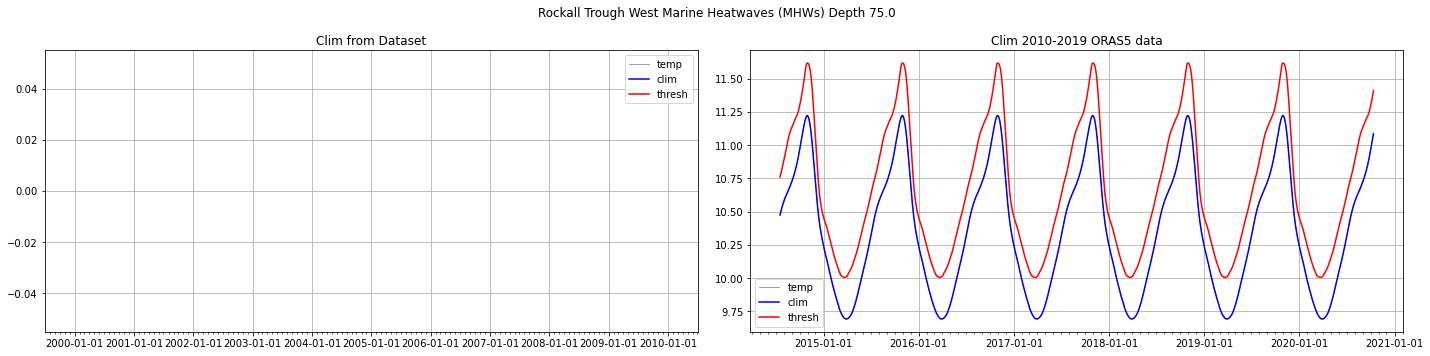

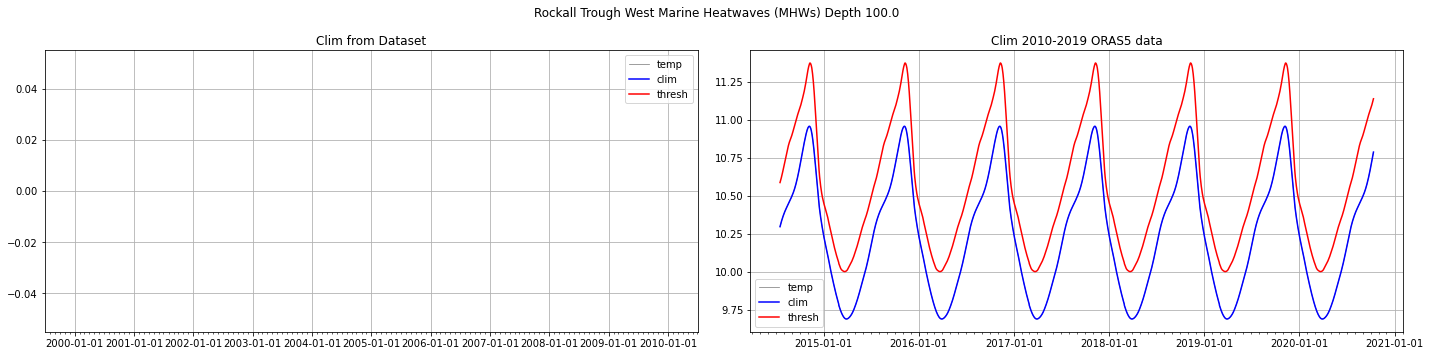

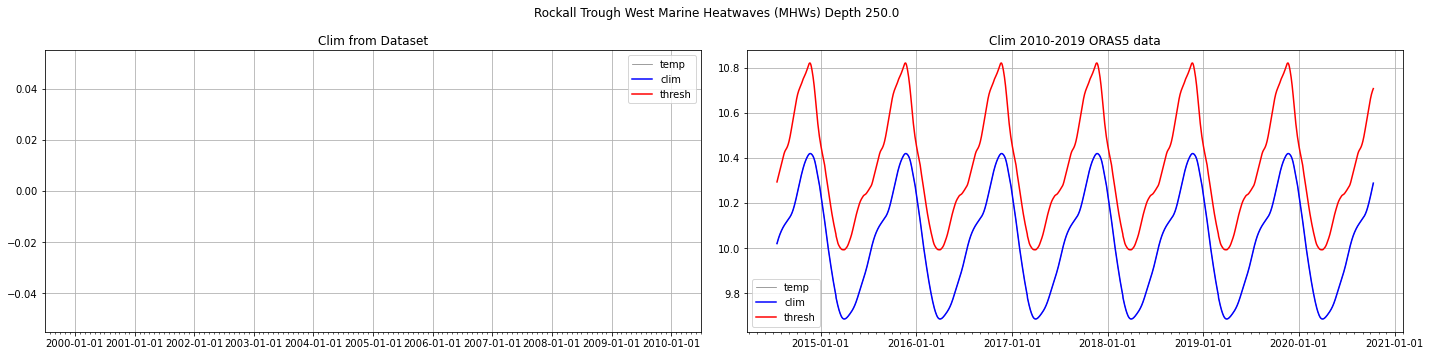

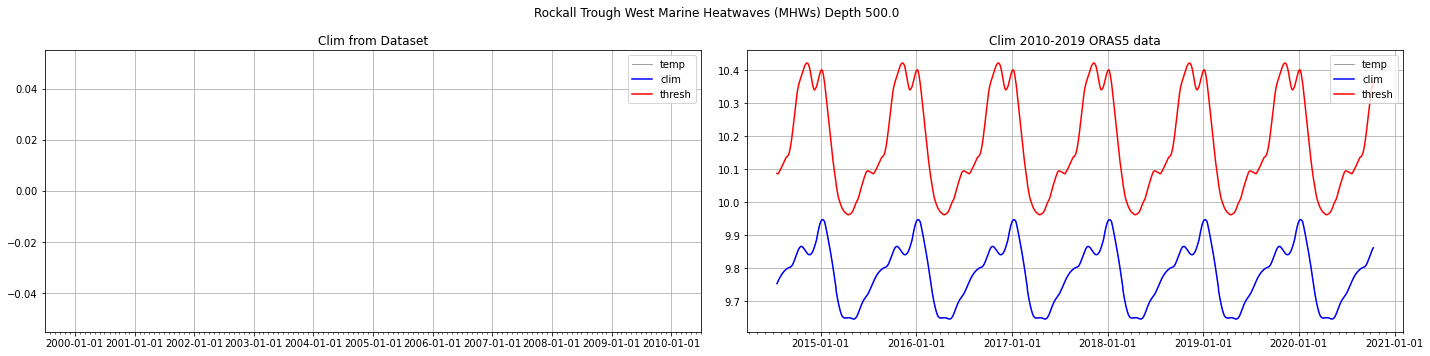

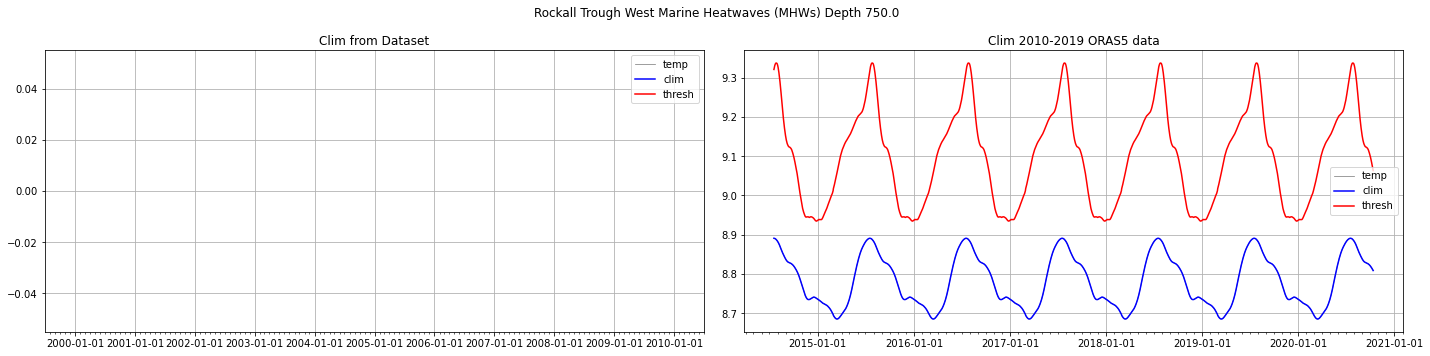

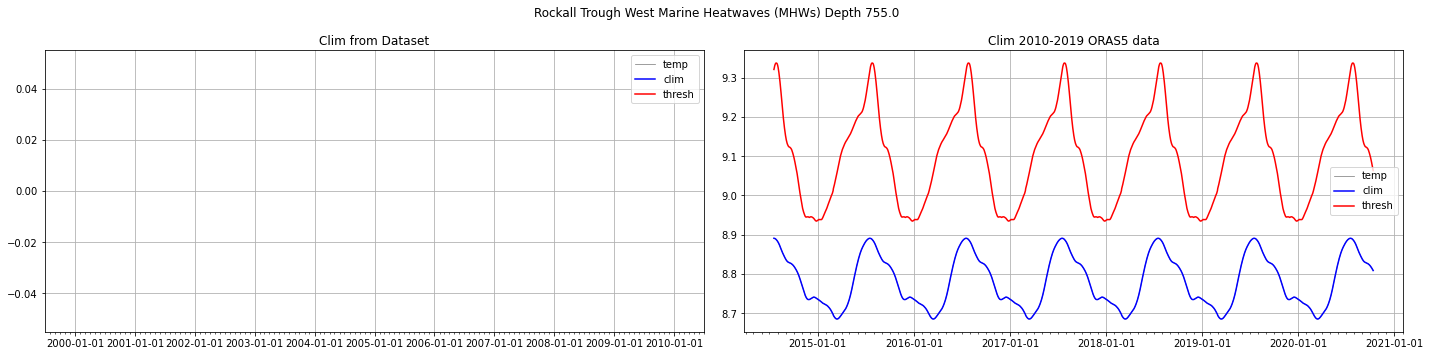

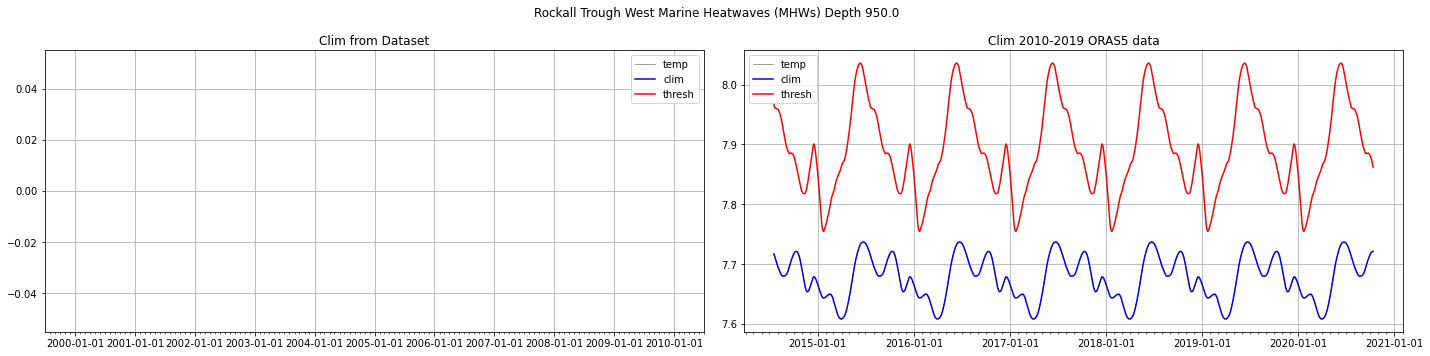

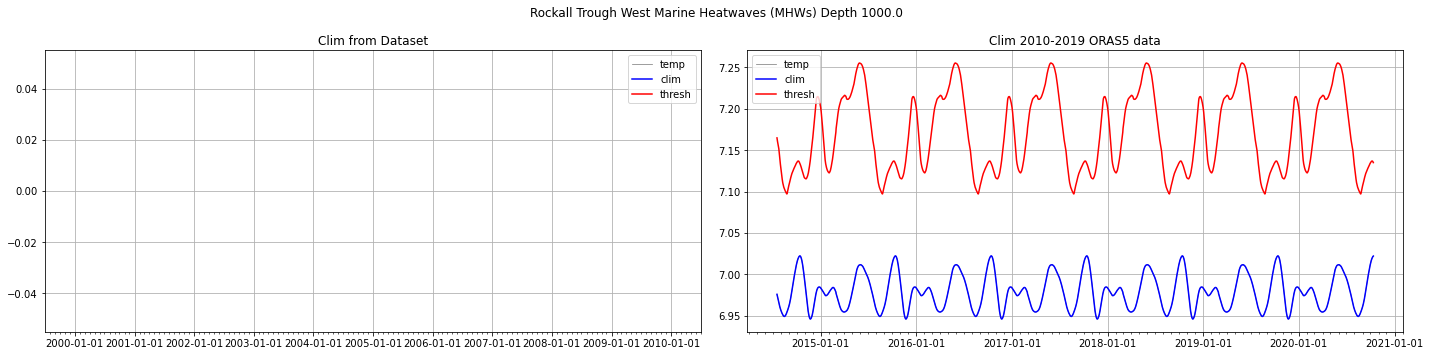

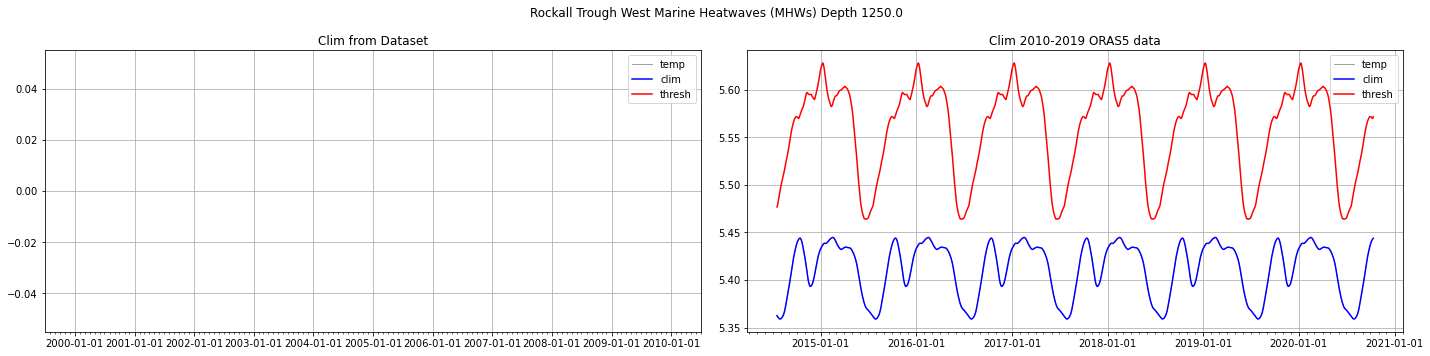

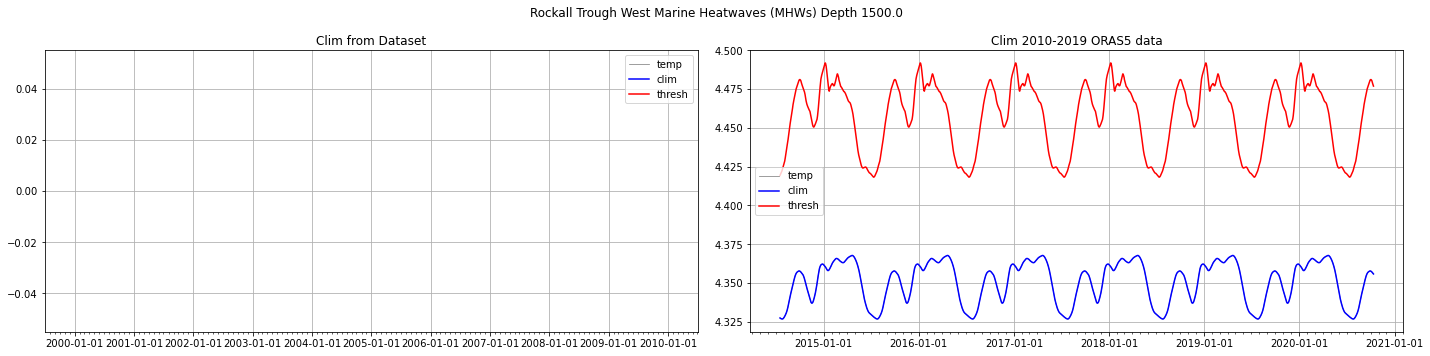

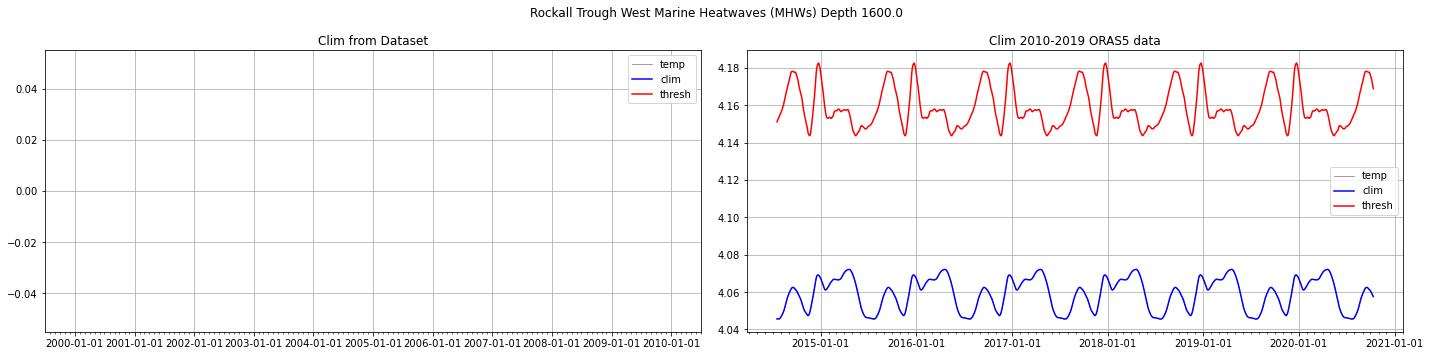

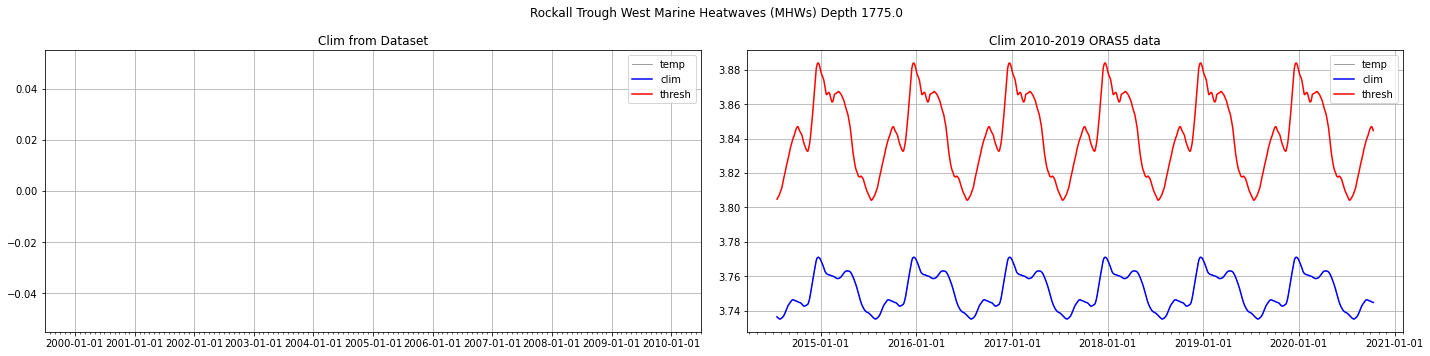

In [23]:
for n in depth_EB:
    fig, ax = plt.subplots(1,2, figsize= (20,5))
    fig.suptitle('Rockall Trough West Marine Heatwaves (MHWs) Depth ' + str(n))
    MHW_plot(ds_eb.time,EB['temp'][str(n)],EB['clim'][str(n)],ax[0])
    ax[0].set_title('Clim from Dataset')
    MHW_plot(ds_eb.time,oras5_EB_10['temp'][str(n)],oras5_EB_10['clim'][str(n)],ax[1])
    ax[1].set_title('Clim 2010-2019 ORAS5 data')
    fig.tight_layout()